In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/ubuntu/sustaingym


In [2]:
!ls

LICENSE		    env_norl.yml	  notebooks
README.md	    epsiode_plot.png	  prices_and_soc_over_episode.png
algo_comp_2019.png  examples		  reward_over_epsiode.png
algo_comp_2021.png  model_PPO_2019_5.zip  sustaingym
env.yml		    mypy.ini


In [3]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.callbacks import EvalCallback, CallbackList, StopTrainingOnNoModelImprovement
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv



from sustaingym.envs import ElectricityMarketEnv
from sustaingym.envs.battery.plot_utils import get_follow_offline_optimal, get_offline_optimal, setup_episode_plot, plot_episode, plot_model_training_reward_curves, plot_reward_distribution, plot_state_of_charge_and_prices, plot_reward_over_episode, run_model_for_evaluation
from sustaingym.envs.battery.wrapped import DiscreteActions

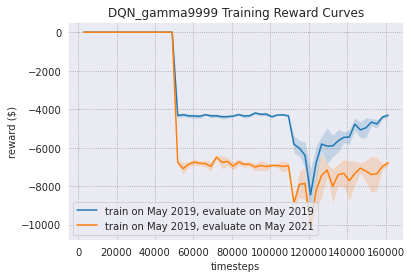

In [8]:
ax = plot_model_training_reward_curves(None, 'DQN_gamma9999', ['in_dist', 'out_dist'])

# plt.savefig('examples/logs_PPO/ppo_reward_curves.png', dpi=300)

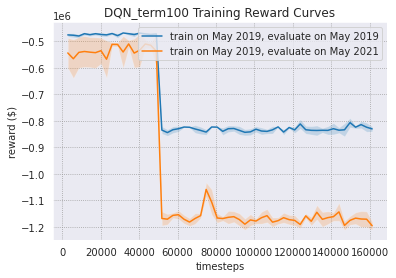

In [9]:
ax = plot_model_training_reward_curves(None, 'DQN_term100', ['in_dist', 'out_dist'])

# plt.savefig('examples/logs_A2C/a2c_reward_curves.png', dpi=300)

KeyboardInterrupt: 

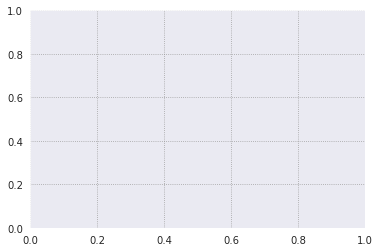

In [8]:
env_2021 = ElectricityMarketEnv(month='2021-05', seed=215)


ppo_2019 = PPO.load('examples/logs_PPO_2019/model_PPO_2019_5.zip')
ppo_2021 = PPO.load('examples/logs_PPO_2021/model_PPO_2021_5.zip')
dqn_2019 = DQN.load('examples/discrete_model_DQN_gamma9999_2019_5.zip')
dqn_2021 = DQN.load('examples/discrete_logs_DQN_2021_5/model_DQN_2021_5.zip')

ax = plot_reward_distribution(None, env_2021, [ppo_2021, ppo_2019, dqn_2021, dqn_2019],
    ['ppo in dist', 'ppo out dist', 'dqn in dist', 'dqn out dist'], '2021')

plt.xticks(rotation=30)

plt.savefig('algo_comp_2021.png', dpi=300)

In [7]:
%debug

> /home/ubuntu/sustaingym/sustaingym/envs/battery/wrapped.py(23)action()
     21 
     22     def action(self, action: int) -> tuple[float, float]:
---> 23         return self.actions[action]
     24 
     25     def _calculate_prices_without_agent(self) -> np.ndarray:

array(2)
*** IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed
*** IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

*** IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed
array(2)
<class 'numpy.ndarray'>


In [20]:
env_2019 = ElectricityMarketEnv(month='2019-05', seed=195)

dqn = DQN.load('examples/discrete_model_DQN_2019_5.zip')

results = run_model_for_evaluation(dqn, 1, DiscreteActions(env_2019))

AttributeError: 'Discrete' object has no attribute 'high'

In [ ]:
# env_2021 = ElectricityMarketEnv(month='2021-05', seed=215)

# ppo = PPO.load('examples/model_PPO_2019_5.zip')
# dqn = A2C.load('examples/discrete_model_DQN_2019_5.zip')

# ax = plot_reward_distribution(None, env_2021, [ppo, dqn],
#     ['ppo out dist', 'dqn out dist'], 10, '2021')

# plt.savefig('algo_comp_2021.png', dpi=300)

In [ ]:
import datetime
import gym
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

df_load = pd.read_csv('sustaingym/data/demand_data/CAISO-demand-2019-05.csv.gz', compression='gzip', index_col=0)

env = ElectricityMarketEnv(month='2019-05', seed=195)
discrete_env = DiscreteActions(env)

a2c = A2C.load('examples/discrete_model_A2C_2019_5.zip')

ax, ax2 = plot_state_of_charge_and_prices(None, df_load, a2c, 'a2c in-dist', discrete_env)

plt.savefig('prices_and_soc_over_episode.png', dpi=300)

In [ ]:
env = ElectricityMarketEnv(month='2019-05', seed=195)
env = DiscreteActions(env)
ppo = PPO.load('examples/discrete_model_PPO_2019_5.zip')

ax, ax2 = plot_reward_over_episode(None, ppo, env)

plt.savefig('reward_over_epsiode.png', dpi=300)

In [15]:
env = ElectricityMarketEnv(month='2019-05', seed=195)

# run offline optimal
env.reset(seed=0)
results = get_offline_optimal(seeds=[0], env=env)
dispatch = results['dispatch']
offline_data = {
    'rewards': results['rewards'][0],
    'prices': results['prices'][0],
    'model_name': 'offline',
    'energy_level': results['energy'][0]
}

# run follow optimal deterministic model
env.reset(seed=0)
follow_rewards, follow_energy, follow_prices = get_follow_offline_optimal(seeds=[0],
                                                env=env, optimal_dispatches=dispatch, optimal_eng_lvl=results['energy'])
follow_offline_data = {
    'rewards': follow_rewards[0],
    'prices': follow_prices[0],
    'model_name': 'follow offline',
    'energy_level': follow_energy[0]
}

# run PPO model
env.reset(seed=0)
ppo = PPO.load('examples/logs_PPO_2019/model_PPO_2019_5.zip')
ppo_results = run_model_for_evaluation(ppo, 1, env, False)

ppo_data = {
    'rewards': ppo_results['rewards'][0],
    'prices': ppo_results['prices'][0],
    'model_name': 'ppo',
    'energy_level': ppo_results['energies'][0],
    'bids': ppo_results['actions'][0]
}

# run DQN model
env.reset(seed=0)
dqn = DQN.load('examples/discrete_model_DQN_gamma9999_2019_5.zip')
dqn_results = run_model_for_evaluation(dqn, 1, env, True)

dqn_data = {
    'rewards': dqn_results['rewards'][0],
    'prices': dqn_results['prices'][0],
    'model_name': 'ppo',
    'energy_level': dqn_results['energies'][0]
}

fig, axs, times = setup_episode_plot(env, '2019-05', include_bids=True)
plot_episode(axs, times, **offline_data)
plot_episode(axs, times, **follow_offline_data)
plot_episode(axs, times, **ppo_data)
plot_episode(axs, times, **dqn_data)

for ax in axs:
    ax.legend()

plt.savefig('epsiode_plot.png', dpi=300)

IndexError: invalid index to scalar variable.

In [14]:
%debug

> /home/ubuntu/sustaingym/sustaingym/envs/battery/plot_utils.py(75)run_model_for_evaluation()
     73             action, _ = model.predict(obs)
     74             if discrete:
---> 75                 actions[i, env.count] = action
     76             else:
     77                 actions[i, env.count, :] = action

array([0.31271517, 0.        ], dtype=float32)
